Breast Cancer 데이터셋을 활용한 다층 퍼셉트론 모델 이진분류

- 목차  
0. 라이브러리 import
1. 데이터 준비
    - 1.1 학습/검증/테스트 데이터 데이터 분리
    - 1.2 데이터 표준화(스케일러)
    - 1.3 Tensor 데이터 변환
2. 미니 배치
3. 모델 준비 (DNN)
4. 학습 및 평가 함수
    - 4.1 학습 함수
    - 4.2 평가 함수
    - 4.3 Early Stopping
    - 4.4 학습 및 검증 수행하는 함수
5. Optuna
6. 최적의 파라미터로 재학습
7. 시각화

## 0. 라이브러리 import

In [17]:
import numpy as np                      
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer # 유방암 데이터셋 예제
from sklearn.model_selection import train_test_split    # 학습/검증/테스트 데이터셋 분리
from sklearn.preprocessing import StandardScaler         # 입력 특성 표준화(z-score)
from sklearn.metrics import (
    accuracy_score,     # 정확도
    roc_auc_score,      # ROC-AUC 점수
    roc_curve,          # ROC 곡선 좌표 계산
    confusion_matrix,   # 혼동행렬 
    ConfusionMatrixDisplay # 혼동행렬 시각화
    )



import torch        # 텐서 조작 및 pytorch 기본 패키지
import torch.nn as nn   # 신경망 레이어 및 모델 저으이
import torch.optim as optim #최적화함수(SGD, ADAM)
from torch.utils.data import TensorDataset, DataLoader # Dataset 구성 및 미니배치 
import optuna   # 하이퍼파라미터 최적화
import warnings     # 파이썬 경고 메시지 제어
warnings.filterwarnings('ignore')   # 불필요한 경고메시지 제거

## 1. 데이터 준비


In [18]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

print(X.shape, y.shape)

(569, 30) (569,)


  - 1.1 학습/검증/테스트 데이터 데이터 분리

In [19]:
# Test 데이터 분리 (모델 최종 성능 평가용)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 전체 데이터의 20%를 테스트로 분리
    random_state=42,    #재현가능성(시드 설정)
    stratify= y # 클래스 비율을 유지하면서 분할
)

print(f"X_trainval:{X_trainval.shape}, X_test:{X_test.shape}, y_trainval:{y_trainval.shape}, y_test{y_test.shape}")

X_trainval:(455, 30), X_test:(114, 30), y_trainval:(455,), y_test(114,)


In [20]:
# Train/Validation 분리 (하이퍼파라미터 튜닝/ 과적합 체크용)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,     # trainval에서 25%를 val로 분리
    random_state=42, 
    stratify=y_trainval     # 전체 비율은 y_trainval 클래스 비율로 유지
)

print(f"X_train:{X_train.shape}, X_val:{X_val.shape}, y_train:{y_train.shape}, y_val{y_val.shape}")

X_train:(341, 30), X_val:(114, 30), y_train:(341,), y_val(114,)


  - 1.2 데이터 표준화(스케일러)

In [21]:
# 입력 데이터 표준화(standardScaler : 평균 0, 표준편차로 스케일 조정). ※ MinMaxScaler : 0~1 사이로 스케일 조정



# Scaler 객체 불러와준다.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) #train데이터만 
X_val = scaler.transform(X_val)    # val 데이터는 학습데이터가 학습한 기준으로 transform만 진행
X_test = scaler.transform(X_test)  # test 데이터는 학습데이터가 학습한 기준으로 transform만 진행

# X_train, X_val, X_test 데이터 학습 및 변환한다. (주의 어떤거는 학습하고 변환하고, 어떤거는 변환만하고)

X_train

array([[-1.22811113, -1.33644026, -1.11371297, ..., -0.1153099 ,
        -0.10649588,  2.76661708],
       [ 0.06195265,  0.56083386,  0.09063509, ...,  0.43138393,
         1.03521763,  0.89563413],
       [-0.42034055, -0.63325474, -0.41461157, ..., -0.45905099,
         0.36524846, -0.49530805],
       ...,
       [-1.06621857, -0.6642126 , -1.01576531, ..., -0.26315237,
        -0.47528624,  0.66149398],
       [ 0.95602833,  1.40996354,  0.94237159, ..., -0.08003933,
        -2.0195959 , -0.88019597],
       [-0.51059424,  0.18933963, -0.48725608, ..., -0.50651929,
        -0.32008696,  0.20016304]], shape=(341, 30))

 ### 1.3 Tensor 데이터 변환

In [22]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (N,) -> (N, 1)로 변환 (출력 SHAPE을 맞춤)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(X_train_t.size(), y_train_t.size())

torch.Size([341, 30]) torch.Size([341, 1])


### 2. 미니 배치

In [23]:
# 학습 , 검증, 테스트용 DataLoader를 생성하는 함수 (학습데이터는 shuffle, 검증 및 테스트 데이터는 고정된 순서)
def make_loader(batch_size = 64):
    train_loader = DataLoader(
        TensorDataset(X_train_t,y_train_t), #학습용 입력(x)와 정답(y) 묶기
        batch_size = batch_size,        #미니배치 크기 설정
        shuffle = True              # 학습데이터는 랜덤으로 섞어 일반화 성능 향상
    )
    val_loader = DataLoader(
        TensorDataset(X_val_t,y_val_t),
        batch_size = batch_size,
        shuffle = False             # 검증 데이터는 순서 고정
    )
    test_loader = DataLoader(
        TensorDataset(X_test_t,y_test_t),
        batch_size = batch_size,
        shuffle = False             # 테스트 데이터도 순서 고정
    )

    return train_loader,val_loader,test_loader # 세 종류의 DataLoader 반환

### 3.모델 준비(DNN)

In [24]:
# 다중 퍼셉트론(MLP) 이진 분류용 모델(출력은 logit 1개)
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_p=0.0):
        super().__init__()              #nn.module 초기화(수동 상태 추적)
        
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)    #입력 -> 첫번쨰 은닉층
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # 두번째 은닉층
        self.fc_out = nn.Linear(hidden_dim2, 1)             # 출력층(logit 1개)
        
        self.act = nn.ReLU()                            #활성화 함수
        self.dropout = nn.Dropout(dropout_p) if dropout_p > 0 else nn.Identity() # Drouout 값 설정 또는 통과
        
    def forward(self, x):
        x = self.act(self.fc1(x))       # 첫번쨰 은닉층 + ReLU
        x = self.dropout(x)             # Dropout 적용 (선택)
        x = self.act(self.fc2(x))       # 두번째 은닉층 + ReLU
        x = self.dropout(x)             # Dropout 적용 (선택)
        x = self.fc_out(x)              # 출력층. 최종 출력(logit)
        
        return x                        #shape : (batch_size, 1)

### 4. 학습 및 평가 함수 및 클래스
###    - 4.1 학습 함수

In [25]:
criterion = nn.BCEWithLogitsLoss()  # 이진분류 손실함수 : 로짓 입력받고 내부에서 Sigmoid + BCE 처리

def train_one_epoch(model, loader, optimizer):
    model.train()               # 학습 모드 전환 (Dropout/batchnorm 등이 있다면 적용)
    losses = []                 # 배치별 loss를 저장할 리스트
    
    for xb, yb in loader:       # 미니배치 단위로 (입력, 정답) 반복
        logits = model(xb)      # 순전파 : 모델 출력(logit) 계산
        loss = criterion(logits, yb)    # 예측(Logit)과 정답(0/1)으로 BCE 손실 계산
        
        optimizer.zero_grad()       # 이전 step 기울기 초기화 
        loss.backward()             # 현재 loss 기준으로 기울기 계산
        optimizer.step()            # 개선된 기울기로 파라미터(가중치/편향) 업데이트
        
        losses.append(loss.item())    # 파이썬 숫자 형태로 loss값 저장
        
    return float(np.mean(losses))   # 1 epoch동안 평균 train_loss 반환 

### 4.2 평가함수

In [26]:
@torch.no_grad()                                # 데코레이터 방식 : 평가시 gradient 계산 비활성화 (속도 향상, 메모리 절약)
def evaluate(model, loader):
    model.eval()                                # 평가모드로 전환(dropout 비활성화, batchnorm 고정 통계 사용-비활성화)
    losses = []                                 # 배치별 loss 누적
    y_true_all = []                             # 실제 정답 누적 저장
    y_prob_all = []                             # 예측 확률 누적 저장
    
    for xb, yb in loader:                       # 미니배치 단위로 반복
        logits = model(xb)                      # 순전파 : 모델 출력 개선
        loss = criterion(logits, yb)            # 검증/테스트 loss 계산
        prob = torch.sigmoid(logits)            # logit -> 확률(0~1) 변환
        
        losses.append(loss.item())              # loss 기록
        y_true_all.append(yb.cpu().numpy())     # 정답을 numpy로 변환해 누적
        y_prob_all.append(prob.cpu().numpy())   # 확률을 numpy로 변환해 누적
        
    y_true = np.vstack(y_true_all).ravel()       # (N, 1) -> (N, ) 형태로 변환
    y_prob = np.vstack(y_prob_all).ravel()       # (N, 1) -> (N, ) 형태로 변환
    y_pred = np.vstack(y_prob > 0.5).astype(int) # 임계값 0.5 기준으로 클래스 (0, 1) 결정
    
    acc = accuracy_score(y_true, y_pred)         # 정확도 계산
    auc = roc_auc_score(y_true, y_pred)          # ROC-AUC 계산(확률 기반)
    
    return float(np.mean(losses)), acc, auc, y_true, y_prob  # 평균 loss, aoc, auc, 정답, 확률 반환

- 데코레이터 방식  
```
@torch.no_grad()
def evaluate():

==

def evaluate():
with torch.no_grad()
```

- 데코레이터 방식을 사용하면 코드가 깔끔해진다.

y_true = np.vstack(y_true_all).revel()

y_true_all = [
    array(([1],[0],[1], ....)),     # 첫 번째 배치
    array(([0],[1],[0], ....)),     # 두 번째 배치
]

np.vstack(y_treu_all)   # vstack  = 세로로 붙이기 (배치들을 하나로 이어붙임)
array([[1],[0],[1],[0],[1],[0],[1],[0],...])

shape : (N,1)
.revel() : 배열을 1차원으로 평탄화(flatten)
array([1, 0, 1, 0, 1, 0, ...])
shape ; (N, 1)

이걸 만드는 이유? accuracy_score 나 roc_auc_score 등 평가함수들이 1차원 배열을 매개값으로 받는다.

y_true = np.vstack(y_true_all).ravel()
== y_true = np.vstack(y_treu_all).reshape(-1)
== y_true = np.vstack(y_treu_all).flatten

###  4.3 Early Stopping

In [27]:
# Early Stopping: 검증 손실이 더 이상 개선되지 않으면 학습을 조기에 중단하는 클래스
class Earlystopping:
    def __init__(self, patience=20, min_delta=0.0):
        self.patience = patience       # 성능 개선이 없어도 허용할 최대 epoch 수
        self.min_delta = min_delta     # 개선으로 인정할 최소 손실 감소량
        self.best = float('inf')       # 지금까지 중 가장 최소의 검증 손실
        self.counter = 0               # 연속으로 개선되지 않은 Epoch 수
        self.stop = False              # 학습 중단 여부 (플래그)
        
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:       # 개선이 된다면
            self.best = val_loss                        # Best 갱신
            self.counter = 0                            # 카운터 초기화
        else:
            self.counter += 1                           # 개선이 없으면 카운터 증가
            if self.counter >= self.patience:             
                self.stop = True                        # patience 초과 시 학습 중단

### 4.4 학습 및 검증 수행하는 함수

In [28]:
def fit(model, train_loader, val_loader, lr=1e-3, n_epochs=200, weight_decay=0.0):
    
    optimizer =optim.Adam(          # Adam 최적화함수 사용
        model.parameters(),         # 학습 대상 파라미터
        lr =lr,                     # 학습률
        weight_decay=weight_decay   # L2 정규화 (과적합 완화)
    )
    
    hist = {"train_loss": [], "val_loss" : [] , "val_acc" : [], "val_auc" : []} # epoch별 기록 저장용 dict
    best_val = np.inf       # 현재까지의 최소 val_loss 저장
    best_state = None       # best 모델의 가중치 저장용
    
    early = Earlystopping(patience=20)  # 20번의 개선사항이 없다면 조기 종료 설정
    
    for epoch in range(1, n_epochs + 1):      
        tr_loss = train_one_epoch(model, train_loader, optimizer)       # 1 epoch 학습 후 train_loss 반환
        va_loss, va_acc, va_auc, _, _, = evaluate(model, val_loader)    # 검증 loss, acc, auc계산
    
        hist['train_loss'].append(tr_loss) 
        hist['val_loss'].append(va_loss)
        hist['val_acc'].append(va_acc)
        hist['val_auc'].append(va_auc)
        
        if va_loss < best_val:          # val_loss가 best_val보다 더 낮아지면
            best_val = va_loss          # 갱신
            best_state ={k: v.cpu().clone() for k, v in model.state_dict().items()} # best 가중치 스냅샷 저장
            
        early.step(va_loss)             # 검증 손실 개선 여부를 확인해 early stopping 상태 갱신
        if early.stop:                  # patienve 만큼 개선이 없으면
            print(f"Early Stopping 실행 epoch : {epoch}")
            break                       # 종료
        
    if best_state is not None:          
        model.load_state_dict(best_state)   # 저장해둔 best 가중치로 모델 복원
                
    return hist # 학습 로그 반환

### 5. optuna 하이퍼파라미터 튜닝

In [29]:
def objective(trial):
    hidden_dim1 = trial.suggest_categorical("hidden_dim1", [32, 64, 128, 256])      # 은닉층 1층 노드 수
    hidden_dim2 = trial.suggest_categorical("hidden_dim2", [16, 32, 64, 128])       # 은닉층 2층 노드 수
    dropout_p = trial.suggest_float('dropout_p', 0.0, 0.5)                          # dropout 비율
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)                            # 학습률(log)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)        # L2 정규화(log)
    batch_size = trial.suggest_categorical('batch_size', [32, 62, 128])             # 배치 크기
    
    train_loader, val_loader, _ = make_loader(batch_size=batch_size)                # loader 생성 (학습/검증)
    
    model = MLP(
        input_dim= X_train.shape[1],    # 입력 차원
        hidden_dim1= hidden_dim1,       # 1층 노드 수
        hidden_dim2= hidden_dim2,       # 2층 노드 수
        dropout_p = dropout_p           # dropout 비율
    )
    
    hist = fit(
        model, train_loader, val_loader,
        lr=lr,      
        n_epochs= 150,
        weight_decay= weight_decay      
    )
    
    best_val_auc = float(np.max(hist["val_auc"]))  #최고 val AUC 반환
    
    return best_val_auc             # optuna 최대화할 최적화할 목적함수

study = optuna.create_study(direction='maximize')   # 목적 함수(val_auc)를 최대화 하도록 optuna study 생성
study.optimize(objective, n_trials=30)              # objective 함수를 30번 실행하며 최적의 하이퍼파라미터 탐색

print("optuna Best Params :", study.best_params)
print("optuna Best Values (val_auc): ", study.best_value)


[I 2026-01-05 17:05:17,565] A new study created in memory with name: no-name-abbdda48-629a-4526-bb21-c0b84a0939a5
[I 2026-01-05 17:05:18,558] Trial 0 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'dropout_p': 0.35709842791966867, 'lr': 0.0012649944267289156, 'weight_decay': 1.8572888472111144e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 77


[I 2026-01-05 17:05:19,351] Trial 1 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 16, 'dropout_p': 0.46803286599905947, 'lr': 0.0001845729237735607, 'weight_decay': 4.054642210568376e-05, 'batch_size': 62}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:19,824] Trial 2 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 64, 'dropout_p': 0.4485842681346931, 'lr': 0.0005165354107394757, 'weight_decay': 9.870316710911327e-05, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 147


[I 2026-01-05 17:05:20,696] Trial 3 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.3301410762917516, 'lr': 0.00013975645067812242, 'weight_decay': 1.230025569570267e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:20,872] Trial 4 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.096334941131903, 'lr': 0.0034917289391314804, 'weight_decay': 3.525878061985958e-06, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 28


[I 2026-01-05 17:05:21,767] Trial 5 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 128, 'dropout_p': 0.4581449722339282, 'lr': 0.0001590956490363537, 'weight_decay': 1.1432551000013889e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:22,085] Trial 6 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.23756197351344216, 'lr': 0.001649187426588377, 'weight_decay': 0.00025962787393389326, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:22,228] Trial 7 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.12000919848922831, 'lr': 0.00470987240792675, 'weight_decay': 3.601826573455529e-05, 'batch_size': 62}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 55
Early Stopping 실행 epoch : 33


[I 2026-01-05 17:05:22,389] Trial 8 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'dropout_p': 0.3179823296162133, 'lr': 0.0032818544622385433, 'weight_decay': 1.3134801111750292e-06, 'batch_size': 62}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:22,570] Trial 9 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'dropout_p': 0.028842454064242518, 'lr': 0.004218006231285605, 'weight_decay': 6.29731895658225e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 35
Early Stopping 실행 epoch : 27


[I 2026-01-05 17:05:22,967] Trial 10 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'dropout_p': 0.2402224415676856, 'lr': 0.0006946676270561464, 'weight_decay': 0.0006527673821939095, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 109


[I 2026-01-05 17:05:23,384] Trial 11 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 32, 'dropout_p': 0.32721734313298145, 'lr': 0.0003618266454281151, 'weight_decay': 6.4711536543724774e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:23,628] Trial 12 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 64, 'dropout_p': 0.35839659552746483, 'lr': 0.0014400614477427995, 'weight_decay': 1.0548271020399e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 63


[I 2026-01-05 17:05:24,481] Trial 13 finished with value: 0.969701932525385 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 16, 'dropout_p': 0.39458931691837573, 'lr': 0.00011582902339411434, 'weight_decay': 1.3919852938296425e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:24,914] Trial 14 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 32, 'dropout_p': 0.28595423070562553, 'lr': 0.0003110068852249779, 'weight_decay': 2.9814961502127865e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:25,236] Trial 15 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 16, 'dropout_p': 0.1817071725321287, 'lr': 0.001127180542612532, 'weight_decay': 1.336062368785656e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 50


[I 2026-01-05 17:05:25,499] Trial 16 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'dropout_p': 0.39398658624292715, 'lr': 0.002041177530937218, 'weight_decay': 2.696309773861015e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 72


[I 2026-01-05 17:05:25,920] Trial 17 finished with value: 0.9742875859810023 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 64, 'dropout_p': 0.20114176096456435, 'lr': 0.0007180821140637415, 'weight_decay': 5.218747482809231e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:26,108] Trial 18 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 32, 'dropout_p': 0.4032566897984473, 'lr': 0.00921275177589065, 'weight_decay': 1.9625672981237604e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 33


[I 2026-01-05 17:05:26,870] Trial 19 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 16, 'dropout_p': 0.2961689223019238, 'lr': 0.00026965843694865585, 'weight_decay': 0.0001420849241861236, 'batch_size': 62}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:27,396] Trial 20 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.3702633191494049, 'lr': 0.0008085808401292604, 'weight_decay': 1.6029866111962645e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:27,948] Trial 21 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.24540096039632803, 'lr': 0.001985965558049818, 'weight_decay': 0.0007316818112752287, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 60


[I 2026-01-05 17:05:28,233] Trial 22 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.18165609609800928, 'lr': 0.0017369031874910812, 'weight_decay': 0.00016651061276766856, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 47


[I 2026-01-05 17:05:28,962] Trial 23 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.27010631073652686, 'lr': 0.00045261875904571887, 'weight_decay': 0.0002997652406318496, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 116


[I 2026-01-05 17:05:29,504] Trial 24 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.3318509185559936, 'lr': 0.001120806304511246, 'weight_decay': 0.00029438465265038997, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 78


[I 2026-01-05 17:05:29,848] Trial 25 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'dropout_p': 0.4962667775423292, 'lr': 0.0026642154088598706, 'weight_decay': 6.6527435324867236e-06, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:30,044] Trial 26 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 64, 'dropout_p': 0.21792401631340808, 'lr': 0.006619345923427255, 'weight_decay': 2.7150124972854608e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 42
Early Stopping 실행 epoch : 29


[I 2026-01-05 17:05:30,390] Trial 27 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 128, 'dropout_p': 0.15797938295288372, 'lr': 0.0012562062429012585, 'weight_decay': 6.059179968885879e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


Early Stopping 실행 epoch : 54


[I 2026-01-05 17:05:31,048] Trial 28 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.4285211374312242, 'lr': 0.0005476449382262396, 'weight_decay': 0.0002918999373665948, 'batch_size': 62}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 17:05:31,698] Trial 29 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 16, 'dropout_p': 0.35996019047319705, 'lr': 0.00018453323794378608, 'weight_decay': 1.8877881243977504e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.


optuna Best Params : {'hidden_dim1': 256, 'hidden_dim2': 32, 'dropout_p': 0.35709842791966867, 'lr': 0.0012649944267289156, 'weight_decay': 1.8572888472111144e-06, 'batch_size': 128}
optuna Best Values (val_auc):  0.9883720930232558


# 최적의 파라미터로 재학습

In [32]:
best = study.best_params        # Optuna가 찾은 최적의 하이퍼 파라미터 가져옴

train_loader, val_loader, test_loader = make_loader(    # 최적의 배치크기로 DataLoader 생성
    batch_size= best['batch_size']
)
best_model = MLP(
    input_dim = X_train.shape[1],           # 입력 차원의 수 (x 의 특성 개수)
    hidden_dim1= best['hidden_dim1'],       # 최적의 첫 번째 은닉층 노드 수. 
    hidden_dim2= best['hidden_dim2'],       # 최적의 두 번째 은닉층 노드 수. 
    dropout_p= best['dropout_p']            # 최적 dropout 비율
)   

history = fit(
    best_model,
    train_loader,                           # train/ val 로더 사용
    val_loader,                             # 최적의 학습률 적용
    lr = best['lr'],
    n_epochs= 300,  
    weight_decay= best['weight_decay']      # 최적의 L2 정규화 규제 수치 적용
)

test_loss , test_acc, test_auc, y_true, y_prob = evaluate(best_model,test_loader)   # 학습이 끝난 모델로 test 데이터 평가

print(
    f"""
    로스: {test_loss:.4f}
    정확도: {test_acc}
    에이유씨: {test_auc:.4f}""")


Early Stopping 실행 epoch : 84

    로스: 0.0931
    정확도: 0.9736842105263158
    에이유씨: 0.9742


# 7. 시각화

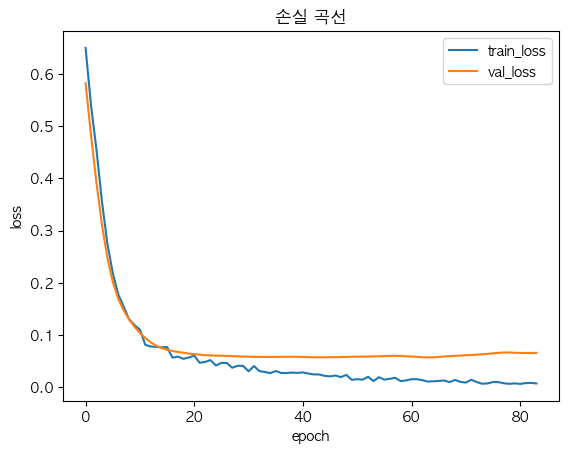

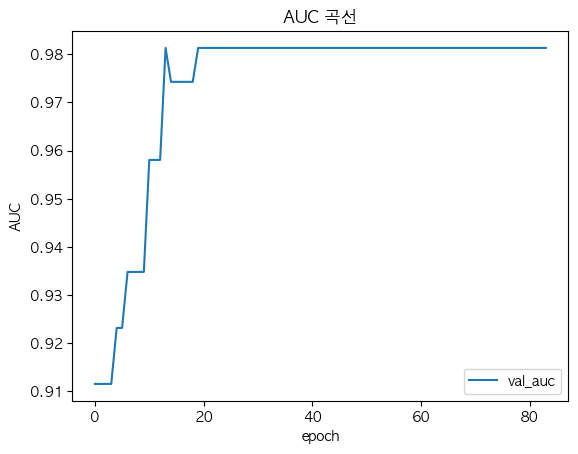

In [ ]:
plt.rcParams["font.family"] = "APPLEGothic"
plt.rcParams["axes.unicode_minus"] = False
# 학습 곡선 (train/val loss ,val AUC)
plt.Figure(figsize = (8, 5))
plt.plot(history["train_loss"], label = "train_loss")
plt.plot(history["val_loss"], label = "val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("손실 곡선")
plt.legend()
plt.show()

plt.Figure(figsize = (8, 5))
plt.plot(history["val_auc"], label = "val_auc")
plt.xlabel("epoch")
plt.ylabel("AUC")
plt.title("AUC 곡선")
plt.legend()
plt.show()

- 손실 곡선 (Loss Curve): 과적합 여부 확인
    - 학습 손실과 검증 손실의 차이를 통해 모델이 학습 데이터를 과도하게 외우고 있는지 판단
    - 학습 손실 곡선은 계속 감소하면서, 검증 손실이 증가하면 과적합의 신호

- AUC 곡선 (AUC Curve) : 분류 성능의 개선 추이를 확인 
    - 모델 의 전반적인 분류 능력이 학습 과정에서 어떻게 변화하는지 확인 
    - auc가 꾸준히 증가하면 클래스 간 구분 능력이 향상되고 있음을 의미
    - 정체되거나 하락하면 추가 학습이 성능 개선으로 이어지지 않음을 확인


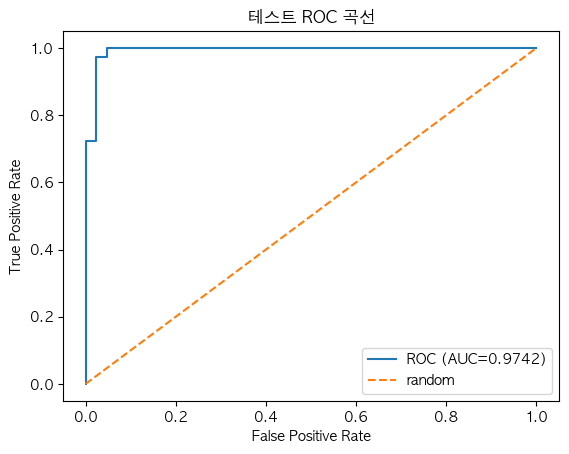

In [37]:
# ROC 곡선  (fpr : False Positive Rate, tpr: True Positive Rate, thr: 임계값)
fpr, tpr, thr = roc_curve(y_true, y_prob)       # 실제값(y_ture)와 예측 확률(y_prob)으로 ROC 곡선 좌표 계산

plt.Figure(figsize = (6, 6))
plt.plot(fpr, tpr, label = f"ROC (AUC={test_auc:.4f})")         # 모델의 ROC 곡선 및 AUC 값 표시
plt.plot([0, 1], [0, 1], linestyle = "--", label = "random")    # 대각선 (기준선)
plt.xlabel("False Positive Rate")                               # x축 : 거짓 양성 비율
plt.ylabel("True Positive Rate")                                # y축 : 진실 양성 비율
plt.title("테스트 ROC 곡선")
plt.legend()
plt.show()

- ROC 곡선 : 분류 임계값 변화에 따른 모델의 판별 성능을 시각적으로 평가하는 지표 
    - AUC가 클수록 성능이 좋다 
    - 븐류 기준 임계값을 0 ~ 1 사이에서 변화시키면서, 거짓 양성 비율(FPR)과 참 양성 비율(TPR)의 관계를 나타낸다
    - 이 모델이 양성과 음성을 얼마나 잘 구분하는지를 확인할 수 있다.
    - AUC는 ROC 곡선 아래 면적으로, 무작위로 하나의 양성과 음성을 선택했을때 모델이 올바르게 순서를 매길 확률을 해석 할 수있다.

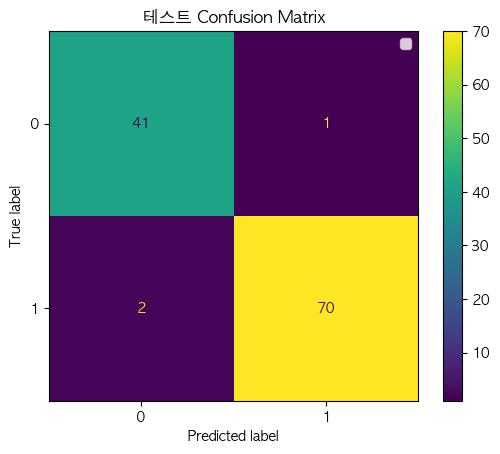

In [39]:
# 혼동 향렬 A(Confusion Matrix)
y_pred = (y_prob > 0.5).astype(int)                 # 예측확률을 임계값 0.5 기준으로 이진 클래스 (0/1)로 변환
cm = confusion_matrix(y_true, y_pred)               # 실제값과 예측값을 비교해 혼동행렬 계산
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # 혼동행렬 시각화 객체 생성
disp.plot()                                                 
plt.title("테스트 Confusion Matrix")
plt.legend()
plt.show()

- 혼동행렬은 각 클래스별로 얼마나 맞추고 틀렸는지를 숫자로 보여준다.   
 그래서 모델의 오류 유형을 분석하는데 용이하다 

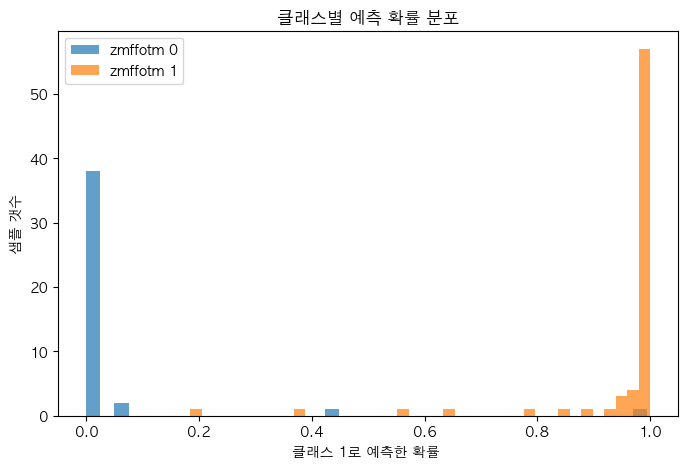

In [ ]:
# 클래스별 예측 확률 분포 
plt.figure(figsize=(8, 5))
plt.hist(
    y_prob[y_true == 0],        # 실제 클래스 0에 대한 예측 확률
    bins = 40,
    alpha = 0.7,                # 투명도 0.7
    label = "zmffotm 0"
)
plt.hist(
    y_prob[y_true == 1],        # 실제 클래스 1에 대한 예측 확률
    bins = 40,
    alpha = 0.7,
    label = "zmffotm 1"
)

plt.xlabel("클래스 1로 예측한 확률 ")
plt.ylabel("샘플 갯수")
plt.title("클래스별 예측 확률 분포")
plt.legend()
plt.show()

- 클래스 별 예측 확률 분포는 모델이 두 클래스를 얼마나 명확하게 구분하고 있는지를 보여주는 시각화 자료이다.
    - x축 : 모델이 클래스 1일 확률이라고 예측한 값
    - 색상 : 파랑색(실제 클래스 0), 주황색(실제 클래스 1)
    - 틀린 예측  
        - 파랑색에 있는 주황색 => 모델이 클래스 1을 클래스 0으로 판단 (False Negative)
        - 주황색에 있는 파랑색 => 모델이 클래스 0을 클래스 1로 판단(False Positive)
    - 현재 상태 : 나쁘진 않은 상태 (분류 경계는 명확, 모델의 확신도 높다. AUC가 높을 가능성이 크다)

### 분류모델에서 성능을 끌어올리기 위한 기법
1. 은닉층 변경
2. 하이퍼파라미터 최적화 (Optuna)  
3. 최적화 함수 변경(Adam -> AdamW, NAdam, Radam)  
4. 스케일러 변경(StandardScaler -> MinMaxScaler, RobustScaler)  
5. 클래스 불균형 해소 (SMOTE) : 데이터 증강  

### 과적합 회피 기법    
1. Dropout or BatchNorm  
2. Scheduler : 점진적으로 lr 제어(ReduceLROnplateau 등)  
3. Early Stopping   
4. K-fold Cross Validation (k번 분할해서 평가 진행)